In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import FuncFormatter, MaxNLocator, MultipleLocator

In [2]:
# Load the two CSVs and add a column to distinguish them
df_warm = pd.read_csv("results_warmup.csv")
df_warm["warmup"] = "warmup"
df_no = pd.read_csv("results_nowarmup.csv")
df_no["warmup"] = "no_warmup"

# Combine into a single DataFrame
df = pd.concat([df_warm, df_no], ignore_index=True)

# Convert n to numeric and work in log-space for x-axis
df["log_n"] = np.log2(df["n"])
df.head()

,n,max_levels,k,cpu_ms,cublas_kernel_ms,cublas_total_ms,gpu_kernel_ms,gpu_total_ms,ops_cublas,ops_gpu,gflops_cublas,gflops_gpu,relerr_cublas,relerr_custom,warmup,log_n
0,128,2,6,0.014861,0.021372,24.512375,0.059396,0.507136,32768,14336,1.547251,0.243122,2.080000e-07,2.180000e-07,warmup,7.0
1,128,2,8,0.013337,0.022016,24.007313,0.060676,0.484868,32768,16384,1.492209,0.270950,2.050000e-07,2.250000e-07,warmup,7.0
2,128,2,10,0.012205,0.020224,21.651325,0.056448,0.476416,32768,18432,1.624227,0.327194,2.070000e-07,2.180000e-07,warmup,7.0
3,128,2,12,0.012076,0.021504,23.092850,0.060928,0.489728,32768,20480,1.537670,0.339934,2.140000e-07,2.280000e-07,warmup,7.0
4,128,2,14,0.012588,0.022528,22.956537,0.059904,0.503936,32768,22528,1.474815,0.380638,1.910000e-07,2.200000e-07,warmup,7.0


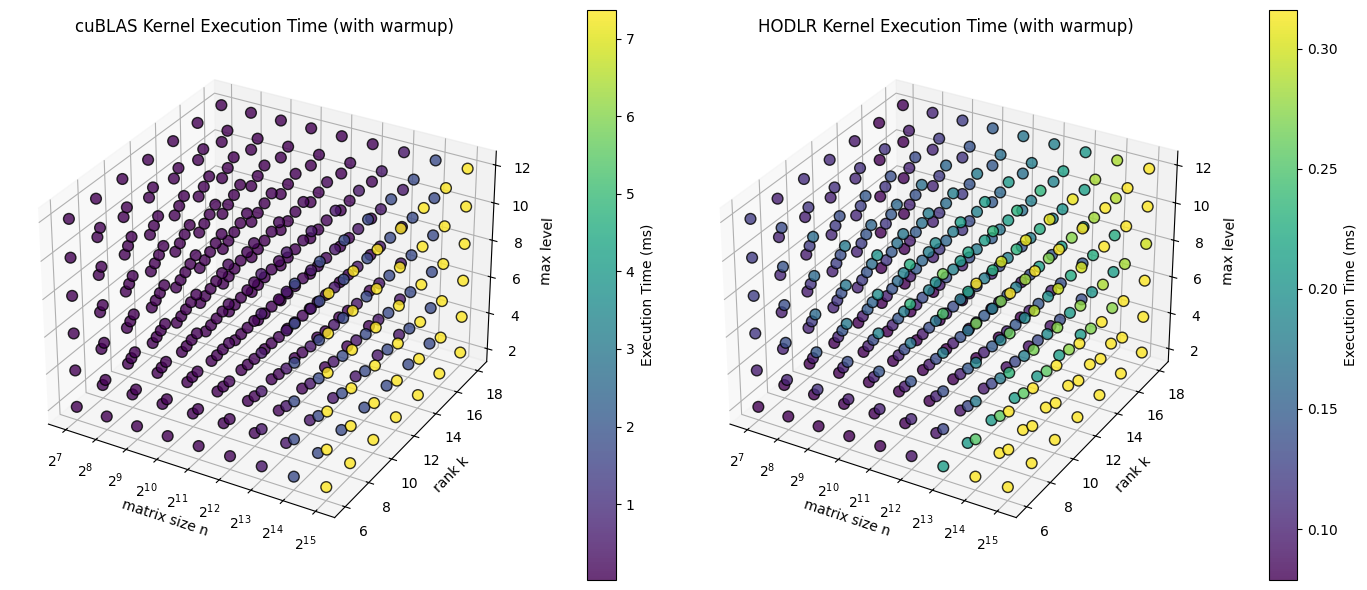

In [3]:
df_warmup = df[df['warmup'] == 'warmup']
fig = plt.figure(figsize=(14, 6))

times_cublas = df_warmup["cublas_kernel_ms"]
vmin_cublas, vmax_cublas = np.percentile(times_cublas, [10, 90])

# 3D scatter for cuBLAS kernel time
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    df_warmup["log_n"], 
    df_warmup["k"], 
    df_warmup["max_levels"],
    c=df_warmup["cublas_kernel_ms"], 
    cmap="viridis",
    vmin=vmin_cublas,
    vmax=vmax_cublas,
    s=60,
    edgecolor="k",
    alpha=0.8
)

ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)

ax1.set_title("cuBLAS Kernel Execution Time (with warmup)")
ax1.set_xlabel("matrix size n")
ax1.set_ylabel("rank k")
ax1.set_zlabel("max level")
cbar1 = fig.colorbar(sc1, ax=ax1, pad=0.1)
cbar1.set_label("Execution Time (ms)")

times_gpu = df_warmup["gpu_kernel_ms"]
vmin_gpu, vmax_gpu = np.percentile(times_gpu, [10, 90])

# 3D scatter for HODLR GPU kernel time
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    df_warmup["log_n"], 
    df_warmup["k"], 
    df_warmup["max_levels"],
    c=df_warmup["gpu_kernel_ms"], 
    cmap="viridis",
    vmin=vmin_gpu,
    vmax=vmax_gpu,
    s=60,
    edgecolor="k",
    alpha=0.8
)

ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
ax2.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)

ax2.set_title("HODLR Kernel Execution Time (with warmup)")
ax2.set_xlabel("matrix size n")
ax2.set_ylabel("rank k")
ax2.set_zlabel("max level")
cbar2 = fig.colorbar(sc2, ax=ax2, pad=0.1)
cbar2.set_label("Execution Time (ms)")

plt.tight_layout()
plt.show()

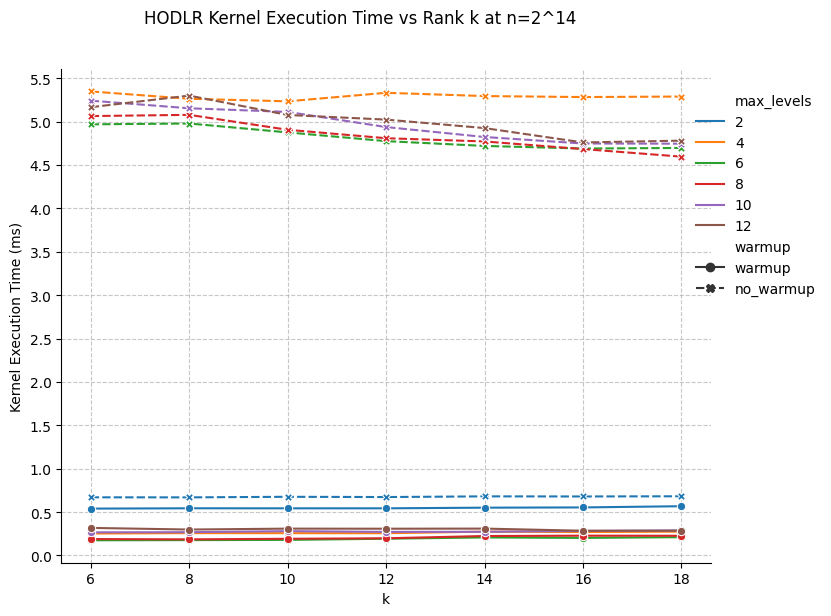

In [29]:
fixed_n = 2**14
df_n = df[df["n"] == fixed_n]

g = sns.relplot(
    data=df_n, x="k", y="gpu_kernel_ms",
    hue="max_levels", style="warmup", kind="line", palette="tab10",
    markers=True, height=6, aspect=1,
    legend="full"
)

# title & labels
g.set_axis_labels("k", "Kernel Execution Time (ms)")
g.fig.suptitle(f"HODLR Kernel Execution Time vs Rank k at n=2^14", y=1.02)

for ax in g.axes.flat:
    ax.grid(True, which="major", linestyle="--", alpha=0.7)
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

sns.move_legend(g, "upper right", bbox_to_anchor=(1.14, 0.9))

plt.tight_layout()
plt.show()

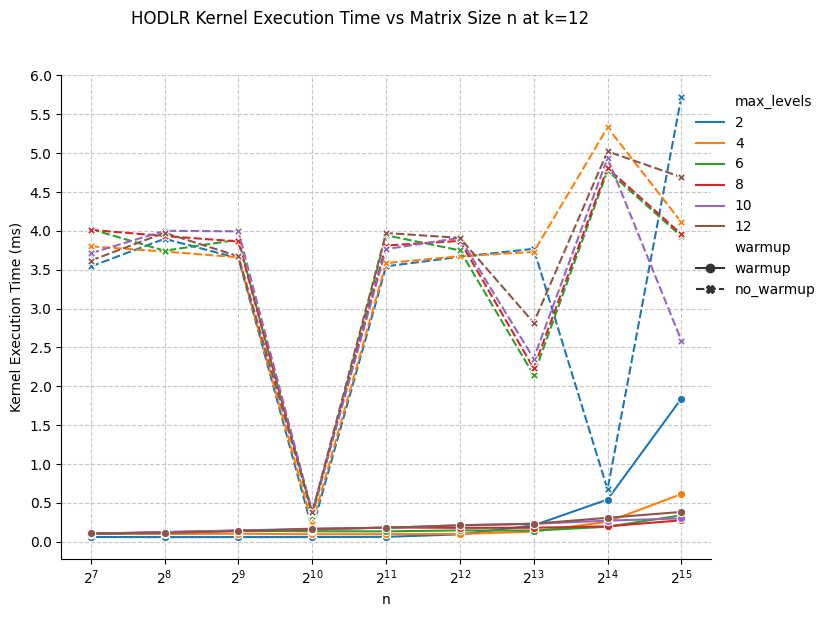

In [30]:
fixed_k = 12
df_k = df[df["k"] == fixed_k]

g = sns.relplot(
    data=df_k, x="log_n", y="gpu_kernel_ms",
    hue="max_levels", style="warmup", kind="line", palette="tab10",
    markers=True, height=6, aspect=1,
    legend="full"
)

# title & labels
g.set_axis_labels("n", "Kernel Execution Time (ms)")
g.fig.suptitle(f"HODLR Kernel Execution Time vs Matrix Size n at k={fixed_k}", y=1.02)

for ax in g.axes.flat:
    ax.grid(True, which="major", linestyle="--", alpha=0.7)
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)
sns.move_legend(g, "upper right", bbox_to_anchor=(1.14, 0.9))

plt.tight_layout()
plt.show()

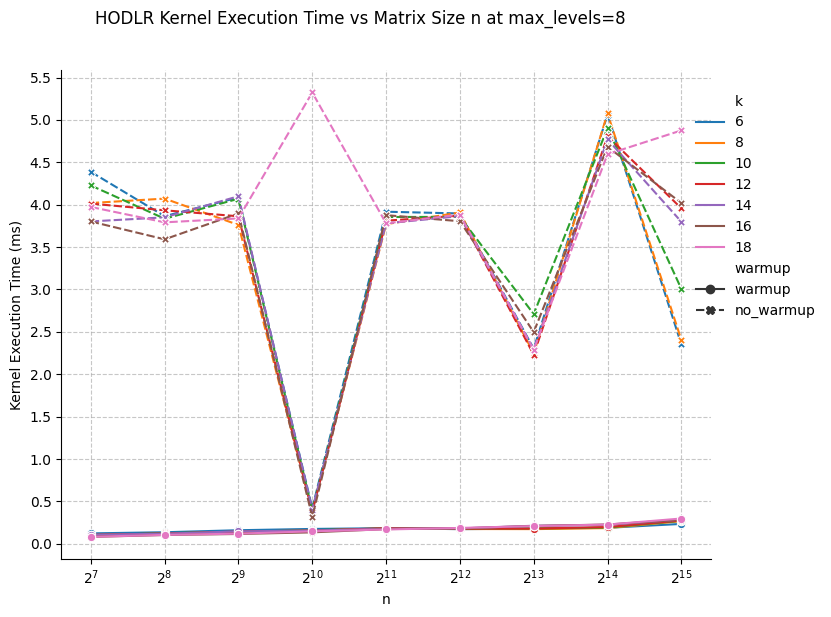

In [31]:
fixed_lvl = 8
df_lvl = df[df["max_levels"] == fixed_lvl]

g = sns.relplot(
    data=df_lvl,
    x="log_n", y="gpu_kernel_ms",
    hue="k", style="warmup",
    kind="line", palette="tab10",
    markers=True,
    height=6, aspect=1,
    legend="full"
)

# title & labels
g.set_axis_labels("n", "Kernel Execution Time (ms)")
g.fig.suptitle(f"HODLR Kernel Execution Time vs Matrix Size n at max_levels={fixed_lvl}", y=1.02)

for ax in g.axes.flat:
    ax.grid(True, which="major", linestyle="--", alpha=0.7)
    ax.yaxis.set_major_locator(MultipleLocator(0.5))

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)
sns.move_legend(g, "upper right", bbox_to_anchor=(1.14, 0.9))

plt.tight_layout()
plt.show()

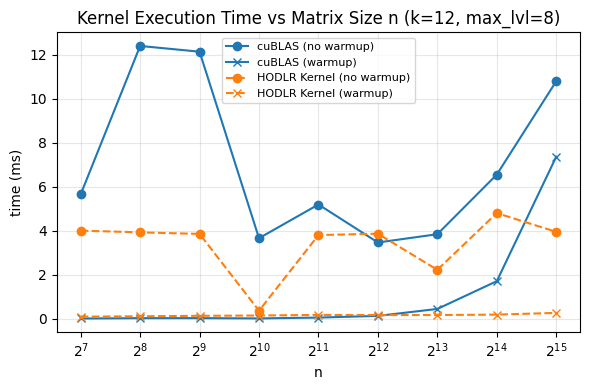

In [7]:
sel = (df["k"] == 12) & (df["max_levels"] == 8)
df_sel = df[sel].sort_values("n")

# unpack
x     = df_sel["log_n"].values
y_cb  = df_sel["cublas_kernel_ms"].values
y_gpu = df_sel["gpu_kernel_ms"].values

# split into two sets per method
mask = df_sel["warmup"] == 'warmup'
x0, x1 = x[~mask], x[mask]
y0_cb, y1_cb   = y_cb[~mask],  y_cb[mask]
y0_gpu, y1_gpu = y_gpu[~mask], y_gpu[mask]

plt.figure(figsize=(6,4))

# cuBLAS: no warmup
plt.plot(x0, y0_cb,
         marker='o', linestyle='-',
         color='C0', label='cuBLAS (no warmup)')
# cuBLAS: with warmup
plt.plot(x1, y1_cb,
         marker='x', linestyle='-',
         color='C0', label='cuBLAS (warmup)')
# HODLR GPU: no warmup
plt.plot(x0, y0_gpu,
         marker='o', linestyle='--',
         color='C1', label='HODLR Kernel (no warmup)')
# HODLR GPU: with warmup
plt.plot(x1, y1_gpu,
         marker='x', linestyle='--',
         color='C1', label='HODLR Kernel (warmup)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)

plt.title("Kernel Execution Time vs Matrix Size n (k=12, max_lvl=8)")
plt.xlabel("n")
plt.ylabel("time (ms)")
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

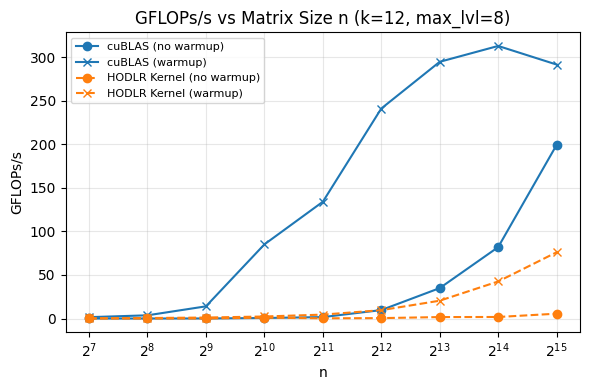

In [8]:
sel = (df["k"] == 12) & (df["max_levels"] == 8)
df_sel = df[sel].sort_values("n")

# unpack
x     = df_sel["log_n"].values
y_cb  = df_sel["gflops_cublas"].values
y_gpu = df_sel["gflops_gpu"].values

# split into two sets per method
mask = df_sel["warmup"] == 'warmup'
x0, x1 = x[~mask], x[mask]
y0_cb, y1_cb   = y_cb[~mask],  y_cb[mask]
y0_gpu, y1_gpu = y_gpu[~mask], y_gpu[mask]

plt.figure(figsize=(6,4))

# cuBLAS: no warmup
plt.plot(x0, y0_cb,
         marker='o', linestyle='-',
         color='C0', label='cuBLAS (no warmup)')
# cuBLAS: with warmup
plt.plot(x1, y1_cb,
         marker='x', linestyle='-',
         color='C0', label='cuBLAS (warmup)')
# HODLR GPU: no warmup
plt.plot(x0, y0_gpu,
         marker='o', linestyle='--',
         color='C1', label='HODLR Kernel (no warmup)')
# HODLR GPU: with warmup
plt.plot(x1, y1_gpu,
         marker='x', linestyle='--',
         color='C1', label='HODLR Kernel (warmup)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)

plt.title("GFLOPs/s vs Matrix Size n (k=12, max_lvl=8)")
plt.xlabel("n")
plt.ylabel("GFLOPs/s")
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

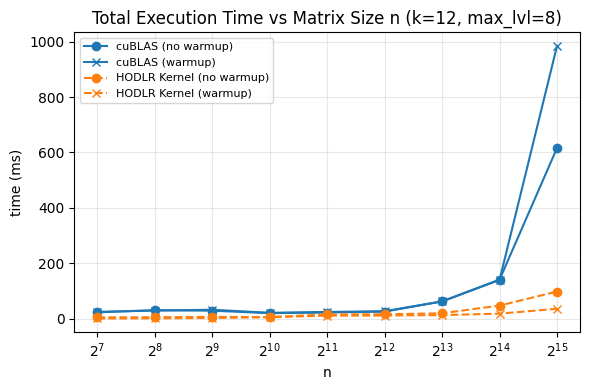

In [9]:
sel = (df["k"] == 12) & (df["max_levels"] == 8)
df_sel = df[sel].sort_values("n")

# unpack
x     = df_sel["log_n"].values
y_cb  = df_sel["cublas_total_ms"].values
y_gpu = df_sel["gpu_total_ms"].values

# split into two sets per method
mask = df_sel["warmup"] == 'warmup'
x0, x1 = x[~mask], x[mask]
y0_cb, y1_cb   = y_cb[~mask],  y_cb[mask]
y0_gpu, y1_gpu = y_gpu[~mask], y_gpu[mask]

plt.figure(figsize=(6,4))

# cuBLAS: no warmup
plt.plot(x0, y0_cb,
         marker='o', linestyle='-',
         color='C0', label='cuBLAS (no warmup)')
# cuBLAS: with warmup
plt.plot(x1, y1_cb,
         marker='x', linestyle='-',
         color='C0', label='cuBLAS (warmup)')
# HODLR GPU: no warmup
plt.plot(x0, y0_gpu,
         marker='o', linestyle='--',
         color='C1', label='HODLR Kernel (no warmup)')
# HODLR GPU: with warmup
plt.plot(x1, y1_gpu,
         marker='x', linestyle='--',
         color='C1', label='HODLR Kernel (warmup)')

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)

plt.title("Total Execution Time vs Matrix Size n (k=12, max_lvl=8)")
plt.xlabel("n")
plt.ylabel("time (ms)")
plt.legend(loc='best', fontsize=8)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

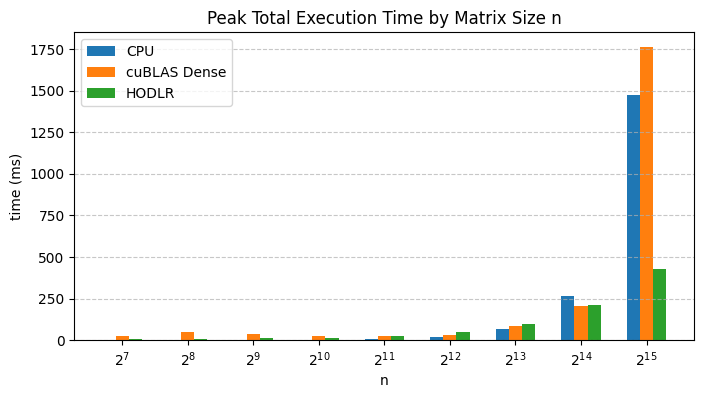

In [10]:
group = df.groupby("log_n").max().reset_index()

plt.figure(figsize=(8,4))
plt.bar(group["log_n"]-0.2, group["cpu_ms"], width=0.2, label="CPU")
plt.bar(group["log_n"]+0.0, group["cublas_total_ms"], width=0.2, label="cuBLAS Dense")
plt.bar(group["log_n"]+0.2, group["gpu_total_ms"], width=0.2, label="HODLR")

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.xlabel("n")
plt.ylabel("time (ms)")
plt.legend()
plt.title("Peak Total Execution Time by Matrix Size n")
plt.show()

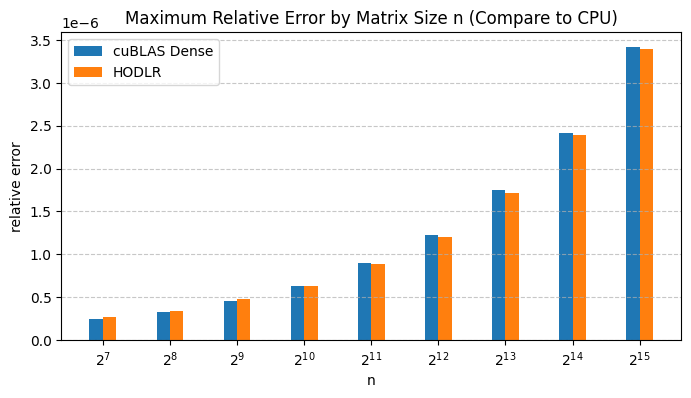

In [11]:
plt.figure(figsize=(8,4))
plt.bar(group["log_n"]-0.1, group["relerr_cublas"], width=0.2, label="cuBLAS Dense")
plt.bar(group["log_n"]+0.1, group["relerr_custom"], width=0.2, label="HODLR")

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, pos: rf"$2^{{{int(x)}}}$")
)
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.xlabel("n")
plt.ylabel("relative error")
plt.legend()
plt.title("Maximum Relative Error by Matrix Size n (Compare to CPU)")
plt.show()